In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random
import numpy as np

In [2]:
def neighbor_edges_of_node(graph, node):
    return [edge for edge in graph.edges() if node in edge]

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph
    

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/pso_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        
        if len(coloring_result) == 1 and coloring_result[0] == -100:
            result_file.write("No solution found.\n")
            print("No solution found.\n")
        
        else:
            result_file.write("Minimum edge coloring found.\n")
            result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
            result_file.write(f"Number of iterations: {iter}\n")

            print("Minimum edge coloring found.")
            print("Number of colors:", len(set(coloring_result)))  
            print("Number of iterations:", iter)
            draw_colored_graph(graph, coloring_result)
            plt.close() 
             

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [8]:

class Particle:
    swarm_best_coloring = None
    swarm_best_value = None
    
    def __init__(self, graph, num_colors, c_i, c_p, c_s):
        self.c_i = c_i
        self.c_p = c_p
        self.c_s = c_s
        
        self.graph = graph
        self.num_colors = num_colors
        self.colors = np.random.randint(0, num_colors, len(graph.edges()))
        self.velocity = np.random.uniform(-1, 1, len(graph.edges()))
        
        self.personal_best_coloring = self.colors.copy()
        self.value = self.calculate_conflicts()
        self.personal_best_value = self.value
        if Particle.swarm_best_value is None or self.value < Particle.swarm_best_value:
            Particle.swarm_best_value = self.value
            Particle.swarm_best_coloring = self.colors.copy()
            
    def calculate_conflicts(self):
        conflicts = 0
        edge_color = {edge: self.colors[i] for i, edge in enumerate(self.graph.edges())}
        for edge in self.graph.edges():
            u, v = edge
            u_edges = neighbor_edges_of_node(self.graph, u)
            v_edges = neighbor_edges_of_node(self.graph, v)
            u_edges.remove(edge)
            v_edges.remove(edge)
            
            for i in range(len(u_edges)):
                if edge_color[u_edges[i]] == edge_color[edge]:
                    conflicts += 1
            
            for j in range(len(v_edges)):
                if edge_color[v_edges[j]] == edge_color[edge]:
                    conflicts += 1
        return conflicts // 2
    
    def update_colors(self):
        self.colors = np.clip(self.colors + self.velocity, 0, self.num_colors - 1)
        self.value = self.calculate_conflicts()
        if self.value < self.personal_best_value and is_valid_coloring(self.graph, self.colors):
            self.personal_best_value = self.value
            self.personal_best_coloring = self.colors.copy()
            if self.value < Particle.swarm_best_value:
                Particle.swarm_best_value = self.value
                Particle.swarm_best_coloring = self.colors.copy()
        else:
            return -100
    
    def update_velocity(self, iteration):
        cognitive_velocity = self.personal_best_coloring - self.colors
        social_velocity = Particle.swarm_best_coloring - self.colors
        r_p = np.random.random(len(cognitive_velocity))
        r_s = np.random.random(len(social_velocity))
        self.velocity = (self.c_i / iteration) * self.velocity + \
                        self.c_p * r_p * cognitive_velocity + \
                        self.c_s * r_s * social_velocity

In [9]:
def pso(graph, swarm_size, num_iters, c_i, c_p, c_s):
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    num_colors = num_nodes  # Inicijalno postavljamo broj boja na broj čvorova
    swarm = [Particle(graph, num_colors, c_i, c_p, c_s) for _ in range(swarm_size)]
    for i in range(num_iters):
        for p in swarm:
            p.update_velocity(i + 1)  # Povećavamo faktor c_i kako se iteracije povećavaju
            p.update_colors()
        # Ažuriramo broj boja ako smo pronašli bolje bojanje
        if Particle.swarm_best_value < num_colors:
            num_colors = Particle.swarm_best_value
            for p in swarm:
                p.num_colors = num_colors
    return Particle.swarm_best_coloring, Particle.swarm_best_value, num_colors



In [10]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    swarm_size = 10  
    num_iters = 100  
    c_i = 0.5  
    c_p = 1 
    c_s = 1  

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_individual, best_value, num_colors = pso(graph, swarm_size, num_iters, c_i, c_p, c_s)
            end_time = time.time()

            coloring_result = best_individual

            write_output(graph, file, coloring_result, num_colors, start_time, end_time) 
            Particle.swarm_best_coloring = None
            Particle.swarm_best_value = None

Running test graph_3_edges.txt...
[0 2 1]
Minimum edge coloring found.
Number of colors: 3
Number of iterations: 0


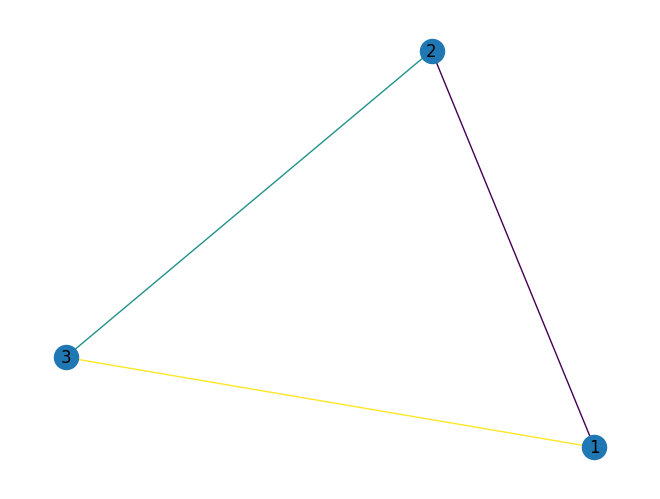

Time taken: 0.14638471603393555 seconds

Running test graph_5_edges.txt...
[1 3 0 3 2]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 0


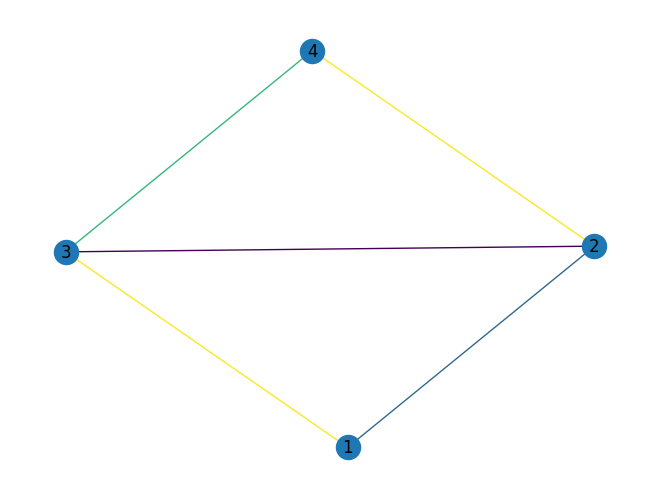

Time taken: 0.10876321792602539 seconds

Running test graph_5_edges_2.txt...
[2 3 1 1 2]
Minimum edge coloring found.
Number of colors: 3
Number of iterations: 0


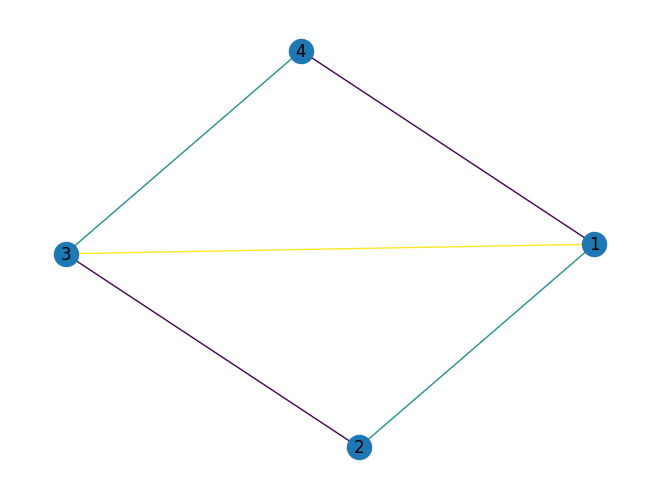

Time taken: 0.24323248863220215 seconds

Running test graph_6_edges.txt...
[4 2 5 1 1 0]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 0


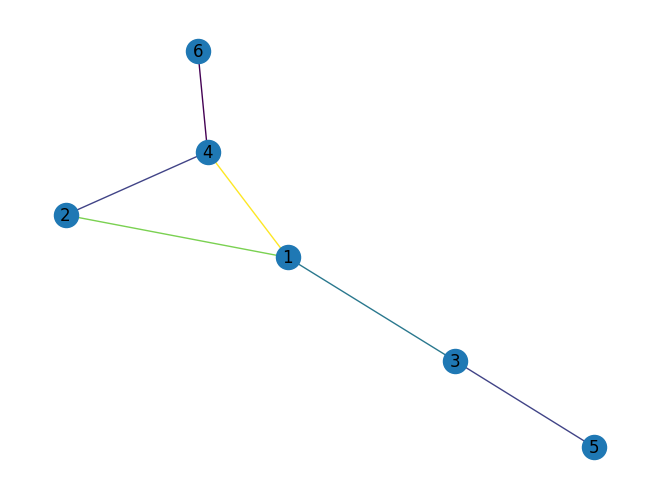

Time taken: 0.16790175437927246 seconds

Running test graph_7_edges.txt...
[1.98602344 0.45060178 0.52049755 2.61639321 0.08095871 1.19847148
 3.62130757]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 0


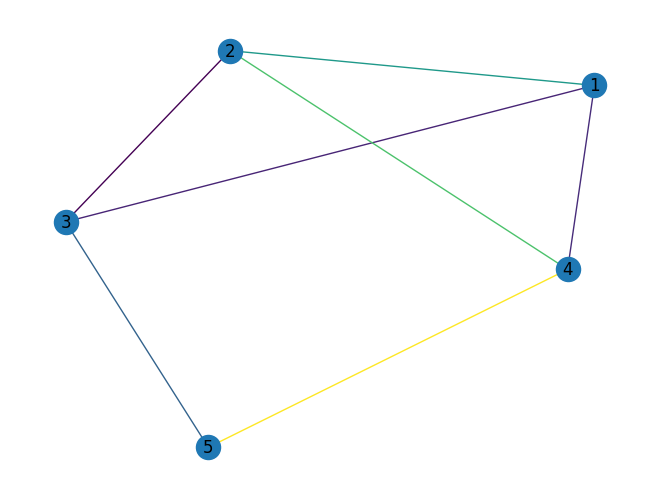

Time taken: 0.16327524185180664 seconds

Running test graph_7_edges_2.txt...
[2 1 3 3 4 2 0]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 0


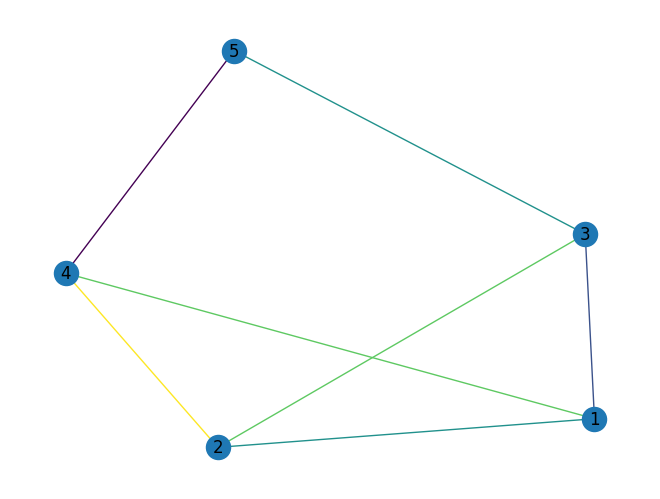

Time taken: 0.14449524879455566 seconds

Running test graph_7_edges_3.txt...
[0 7 2 5 6 6 3]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 0


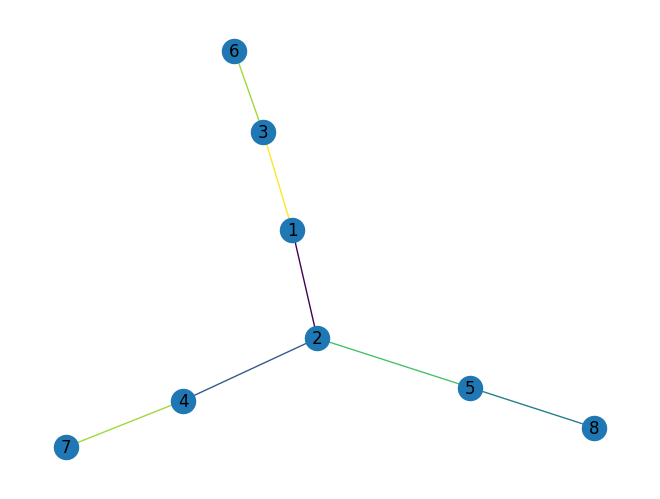

Time taken: 0.14643239974975586 seconds

Running test graph_8_edges.txt...
[5 8 6 8 7 2 5 5]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 0


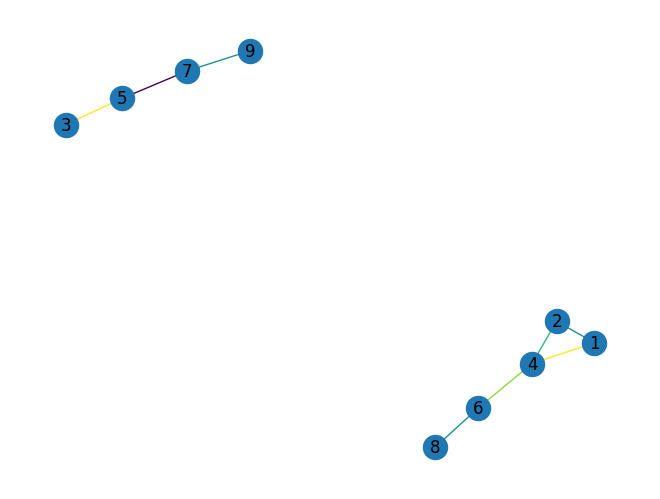

Time taken: 0.17492365837097168 seconds

Running test graph_9_edges.txt...
[0 4 1 5 3 0 0 2 1]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 0


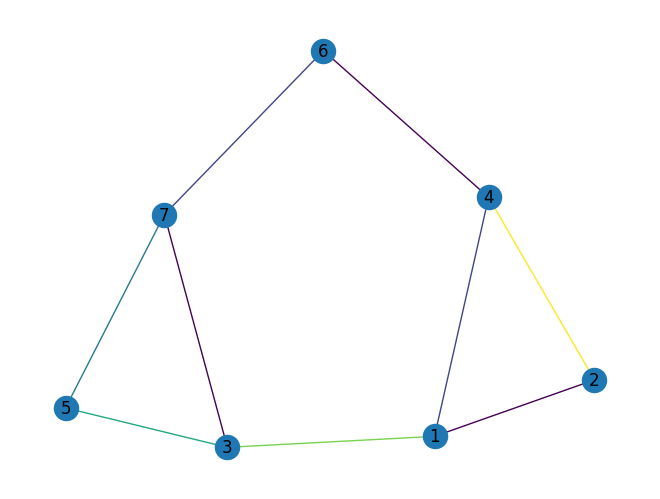

Time taken: 0.19288039207458496 seconds

Running test graph_9_edges_2.txt...
[9 6 4 7 4 3 9 8 2]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 0


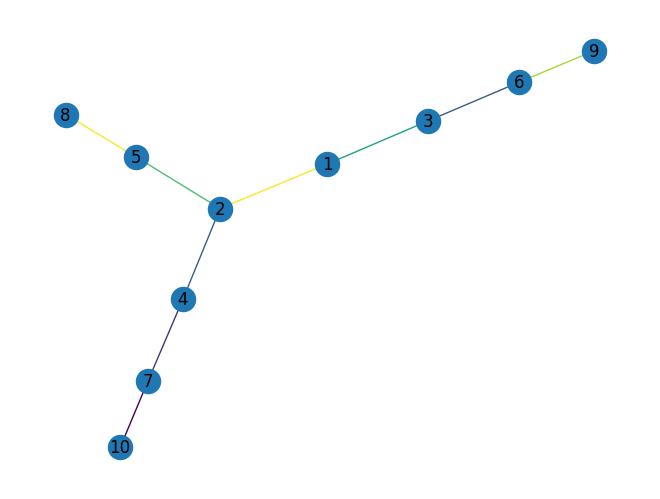

Time taken: 0.22230768203735352 seconds

Running test graph_10_edges.txt...
[10  0  7  2  7  1  6  9  8  9]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 0


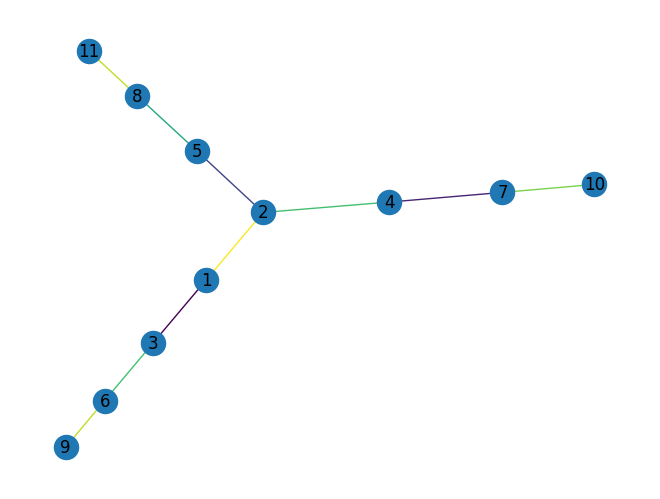

Time taken: 0.24134135246276855 seconds

Running test graph_10_edges_2.txt...
[0.55171112 1.58182786 4.49171642 4.22095319 2.69539013 3.58457941
 2.87542275 0.         0.8790996  4.24487902]
Minimum edge coloring found.
Number of colors: 10
Number of iterations: 0


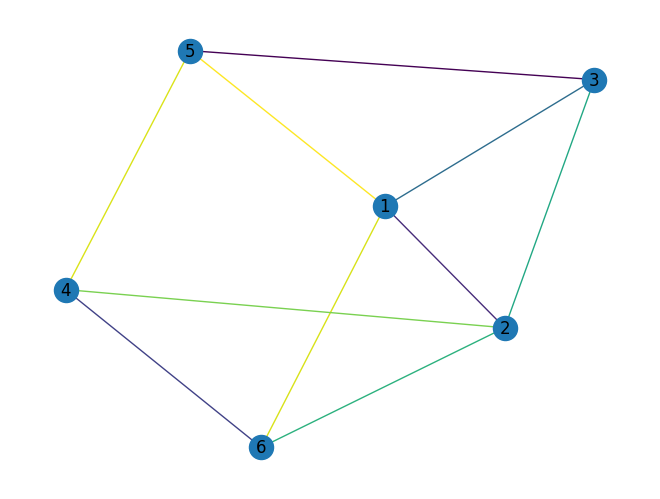

Time taken: 0.259397029876709 seconds

Running test graph_10_edges_3.txt...
[0 9 2 1 2 3 8 0 3 5]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 0


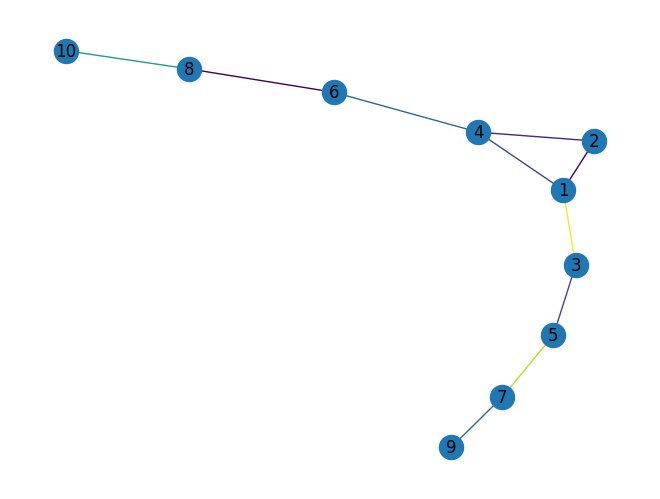

Time taken: 0.2678182125091553 seconds

Running test graph_11_edges.txt...
[0.2609336  3.03549712 3.54970237 2.40629085 0.03153161 4.71172319
 1.07529196 0.         5.13028949 0.12339517 0.71218476]
Minimum edge coloring found.
Number of colors: 11
Number of iterations: 0


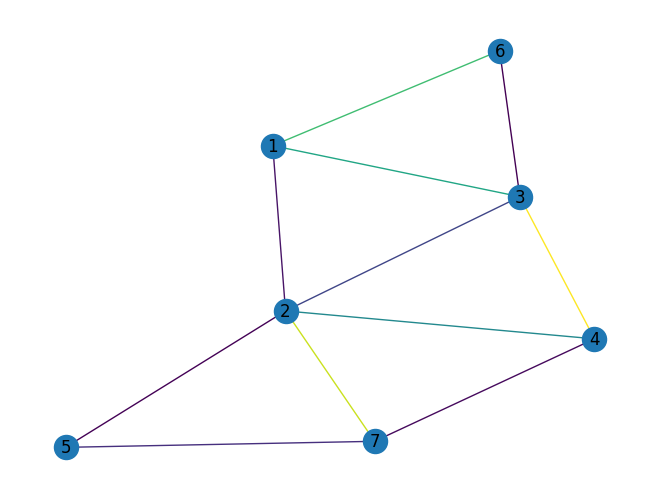

Time taken: 0.25440454483032227 seconds

Running test graph_11_edges_2s.txt...
[7 5 0 1 0 2 3 7 6 1 1]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 0


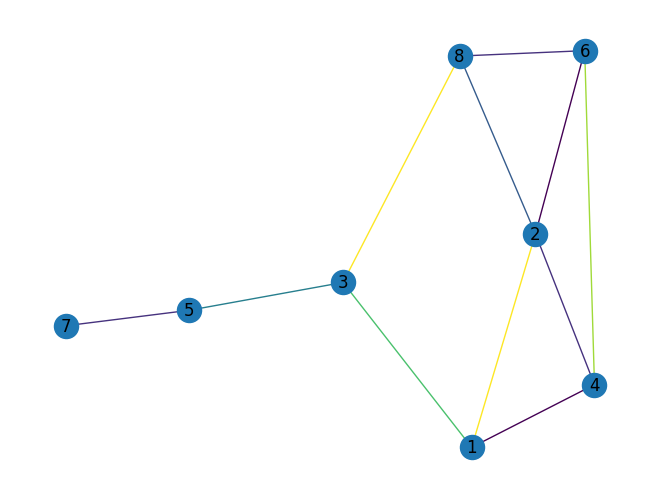

Time taken: 0.2523033618927002 seconds

Running test graph_11_edges_3.txt...
[5 0 4 8 3 9 9 6 2 2 8]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 0


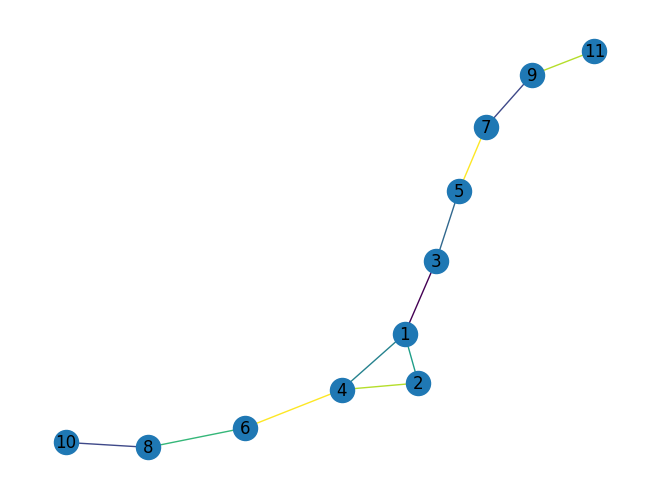

Time taken: 0.2553415298461914 seconds

Running test graph_11_edges_4.txt...
[ 7  9  6  4 11  2  2  1  9  9  4]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 0


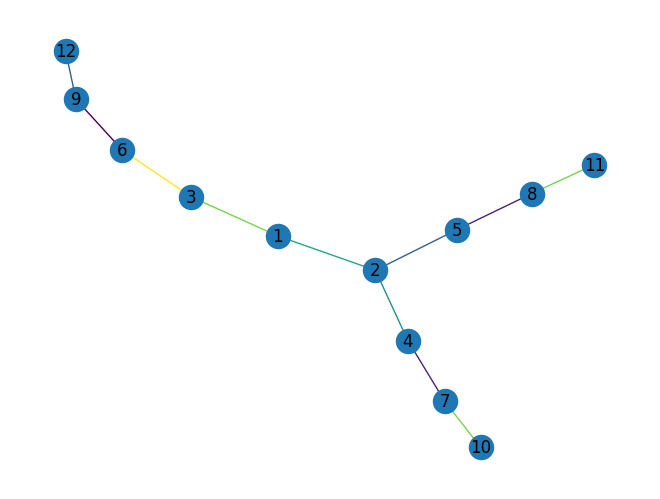

Time taken: 0.31931090354919434 seconds

Running test graph_12_edges.txt...
[ 3  5 11  6 10  1  4  0  0  8  6  7]
Minimum edge coloring found.
Number of colors: 10
Number of iterations: 0


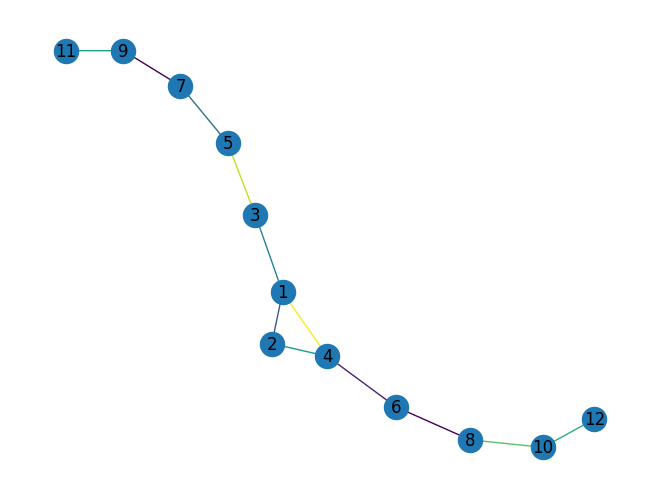

Time taken: 0.32123255729675293 seconds

Running test graph_12_edges_2.txt...
[10  9  2  1  2  5  8 10  3  2  6  6]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 0


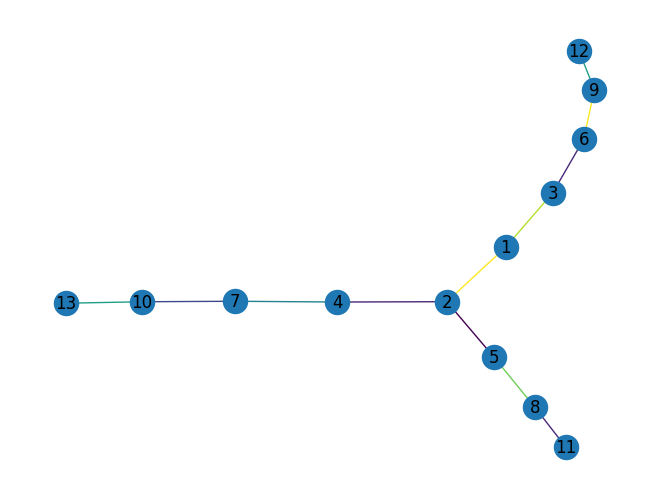

Time taken: 0.3505222797393799 seconds

Running test graph_15_edges.txt...
[0.2856119  3.7185151  5.49138065 2.00052182 1.0941643  0.
 3.21093933 7.6768999  1.44899696 0.31495796 6.2166997  5.20653563
 5.0077667  4.82411522 5.0320851 ]
Minimum edge coloring found.
Number of colors: 15
Number of iterations: 0


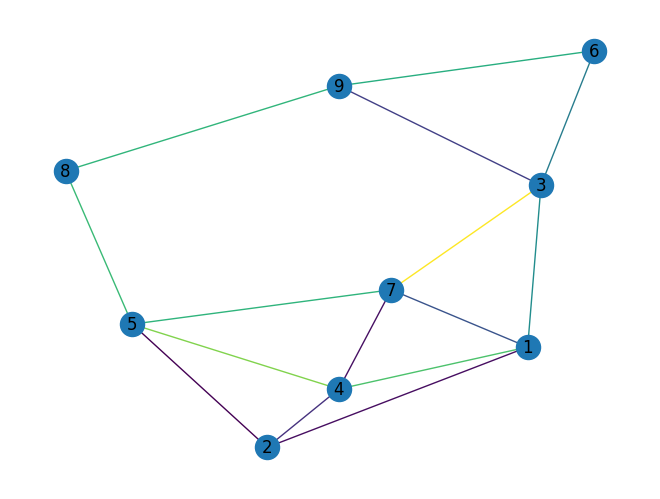

Time taken: 0.3563423156738281 seconds



In [11]:
with open('./results/pso_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')